In [1]:
from src.uts import parse_files
from pathlib import Path
from bs4 import BeautifulSoup
import pandas as pd

l = []
uts = parse_files(list(Path('.data/corrected/').glob('*.tsv')))
# # version dépliée
# for ut in uts:
#     soup = BeautifulSoup(ut[2], features='xml')
#     for t in soup.find_all('span'):
#         if 'ana' in t.attrs: # and t.attrs['type'] not in ['NULL', 'NEUTRAL', 'CIVILITY']:
#             l.append((soup.find('u').attrs['who'], t.attrs['ana'], t.attrs['type']))
# df = pd.DataFrame(l, columns=['speaker', 'target', 'type'])
#version pliée
df = pd.DataFrame([(BeautifulSoup(ut[2], features='xml').find('u').attrs['who'], t.attrs['ana'], t.attrs['type']) for ut in uts for t in BeautifulSoup(ut[2], features='xml').find_all('span') if 'ana' in t.attrs and t.attrs['type'] not in ['NULL', 'NEUTRAL', 'CIVILITY']], columns=['speaker', 'target', 'type'])

In [3]:
import plotly.graph_objects as go
import networkx as nx
from collections import Counter
from distinctipy import distinctipy
import matplotlib.pyplot as plt

In [4]:
speaker = '#vedel_georges'
df_sp = df[df['speaker']==speaker]
val = dict(Counter([c for c in zip(df_sp.speaker, df_sp.target+'_'+df_sp.type)]))

In [ ]:
for speaker in df.speaker.unique():
    df_sp = df[df['speaker']==speaker]
    print(speaker)
    print(pd.DataFrame([(speaker, target, len(df_sp[(df_sp['target']==target) & (df_sp['type']=='POSITIF')])/(len(df_sp[(df_sp['target']==target) & (df_sp['type']=='NEGATIF')])+len(df_sp[(df_sp['target']==target) & (df_sp['type']=='POSITIF')]))*100, len(df_sp[(df_sp['target']==target) & (df_sp['type']=='NEGATIF')])+len(df_sp[(df_sp['target']==target) & (df_sp['type']=='POSITIF')])) for target in df_sp.target.unique()], columns=['speaker', 'target', '% interactions positives', 'nb interactions totales']))

In [ ]:
for target in df_sp.target.unique():
    print(speaker, target)
    print(len(df_sp[(df_sp['target']==target) & (df_sp['type']=='POSITIF')])/(len(df_sp[(df_sp['target']==target) & (df_sp['type']=='NEGATIF')])+len(df_sp[(df_sp['target']==target) & (df_sp['type']=='POSITIF')]))*100)
    print((len(df_sp[(df_sp['target']==target) & (df_sp['type']=='NEGATIF')])+len(df_sp[(df_sp['target']==target) & (df_sp['type']=='POSITIF')])))

In [ ]:
# val = {('#giscard-d-estaing_valery', '#frey_roger'): 1,('#frey_roger', '#giscard-d-estaing_valery'): 1,  ('#frey_roger', '#lecourt_robert'): 2,  ('#frey_roger', '#lecourt_robert'): 1,('#brouillet_rene', '#vedel_georges'): 1, ('#segalat_andre', '#brouillet_rene'): 1, ('#frey_roger', '#brouillet_rene'): 1, ('#vedel_georges', '#segalat_andre'): 1, ('#lecourt_robert', '#monnerville_gaston'): 1, ('#lecourt_robert', '#vedel_georges'): 2}
plt.figure(figsize=(6,5)) 

G = nx.MultiDiGraph(multigraph_input=True)
for item in val.items():
    G.add_edge(*item[0], weight=item[1])

# nx.draw_networkx(G, pos=nx.circular_layout(G), with_labels=True, node_color=distinctipy.get_colors(len(G.edges())+1), font_size=8)
# for edge in G.edges(data='weight'):
    # nx.draw_networkx_edges(G, nx.circular_layout(G), edgelist=[edge], width=edge[2], arrows=True, arrowsize=10)

# plt.show()

In [22]:
def normalize(item):
  t = sum([v for v in item.values()])
  for k in item:
    item[k] /= t

In [20]:
from collections import defaultdict
d = defaultdict(dict)
for n in df_sp.groupby(['target', 'type']).count().iterrows():
    d[n[0][0]][n[0][1]]=n[1][0]

In [23]:
for v in d.values():
    normalize(v)

<Figure size 1000x1000 with 0 Axes>

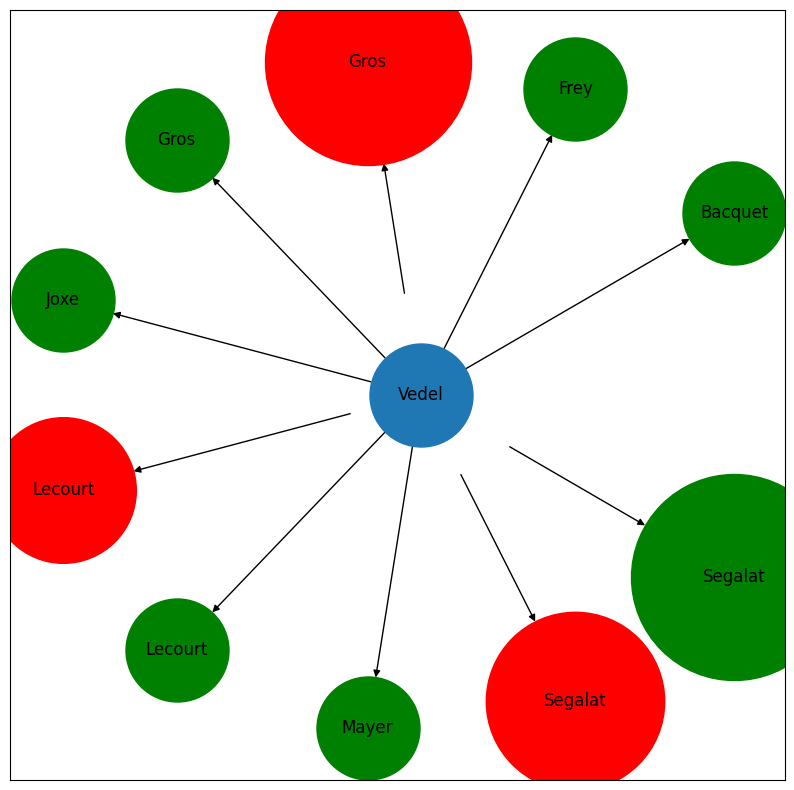

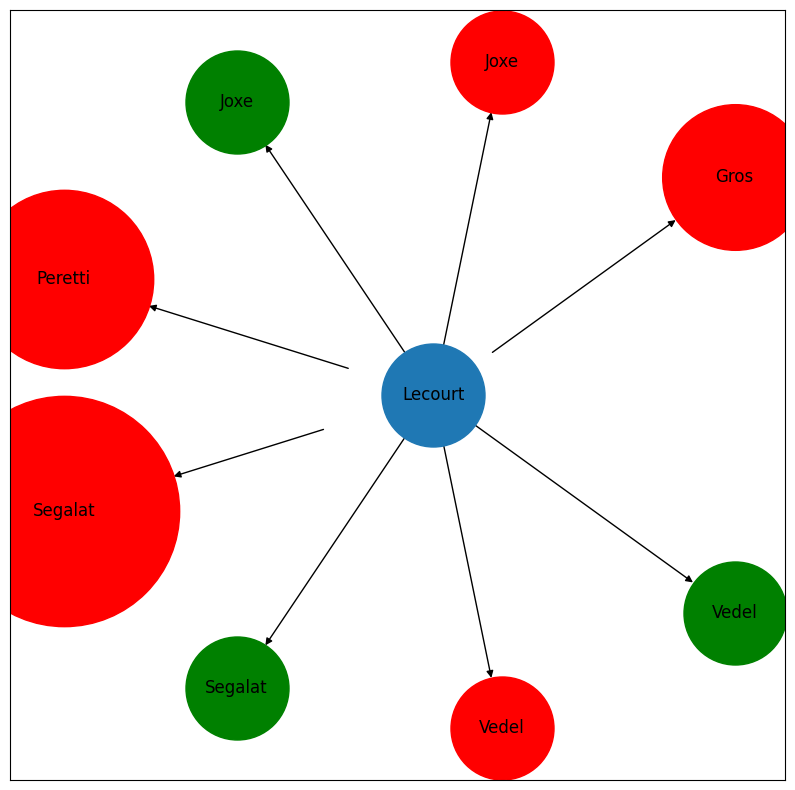

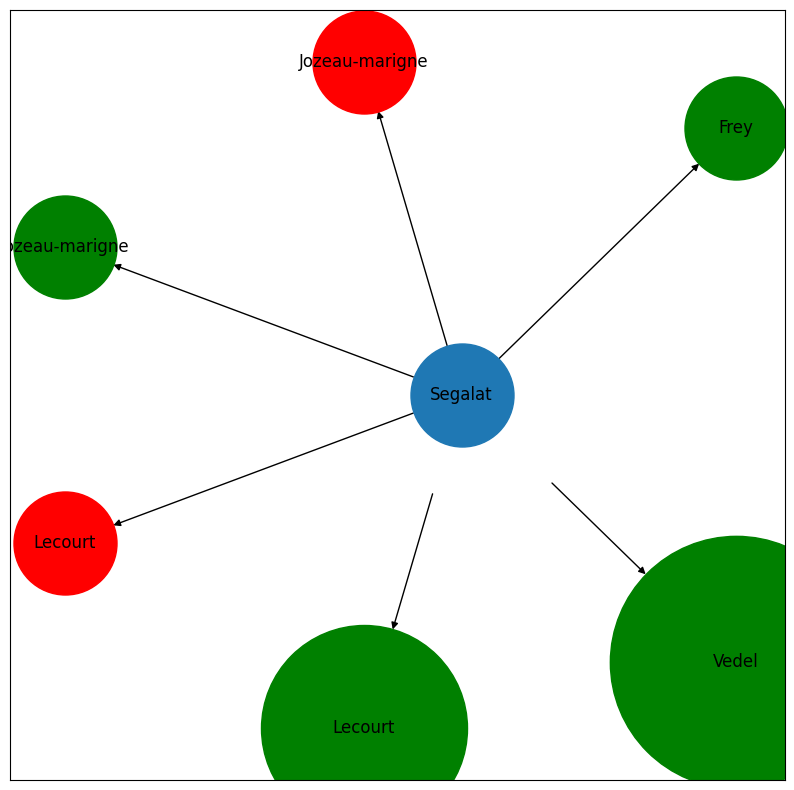

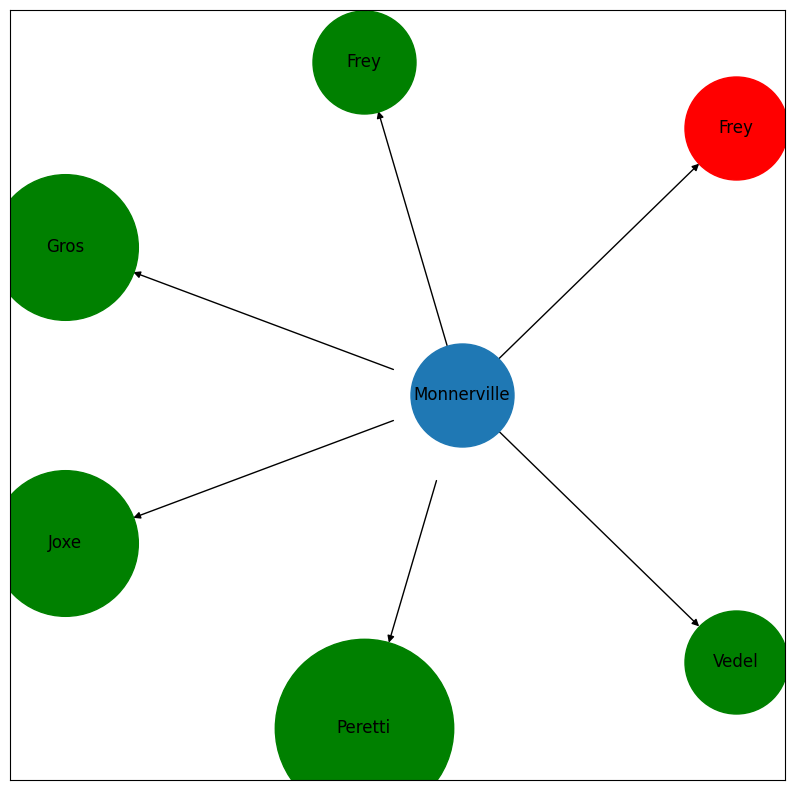

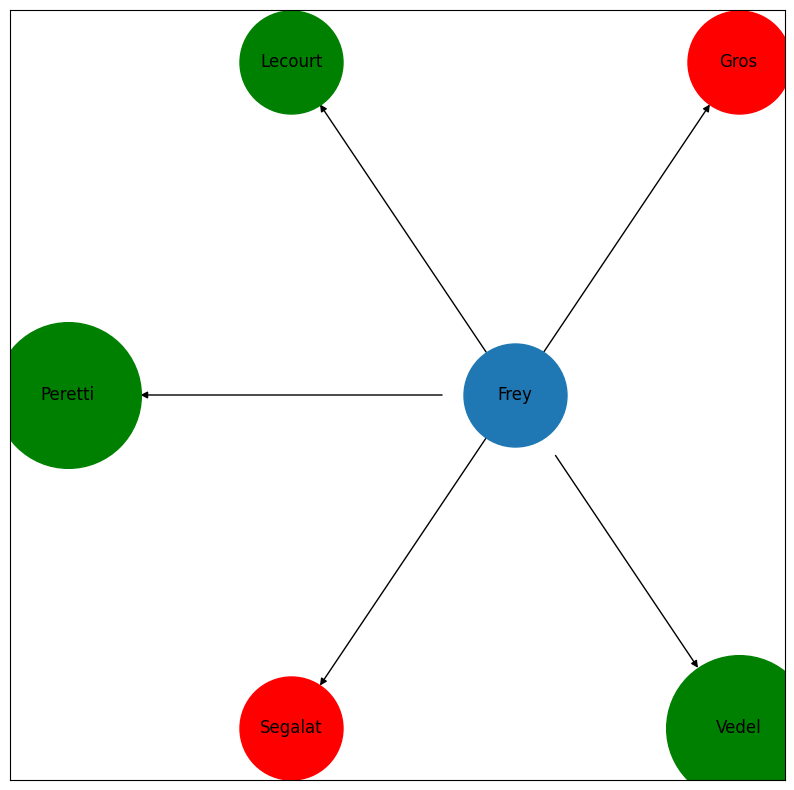

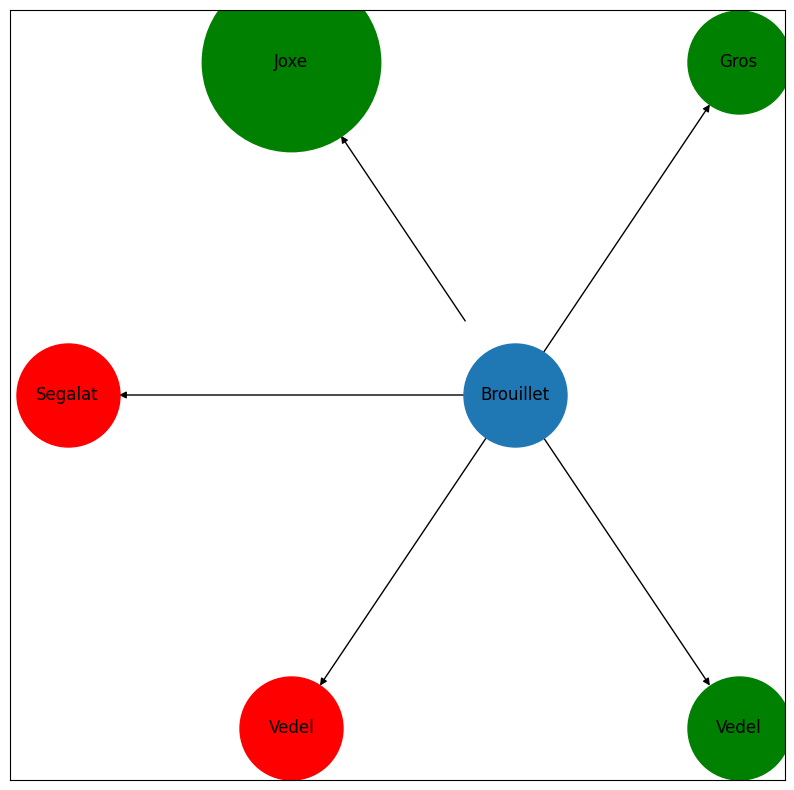

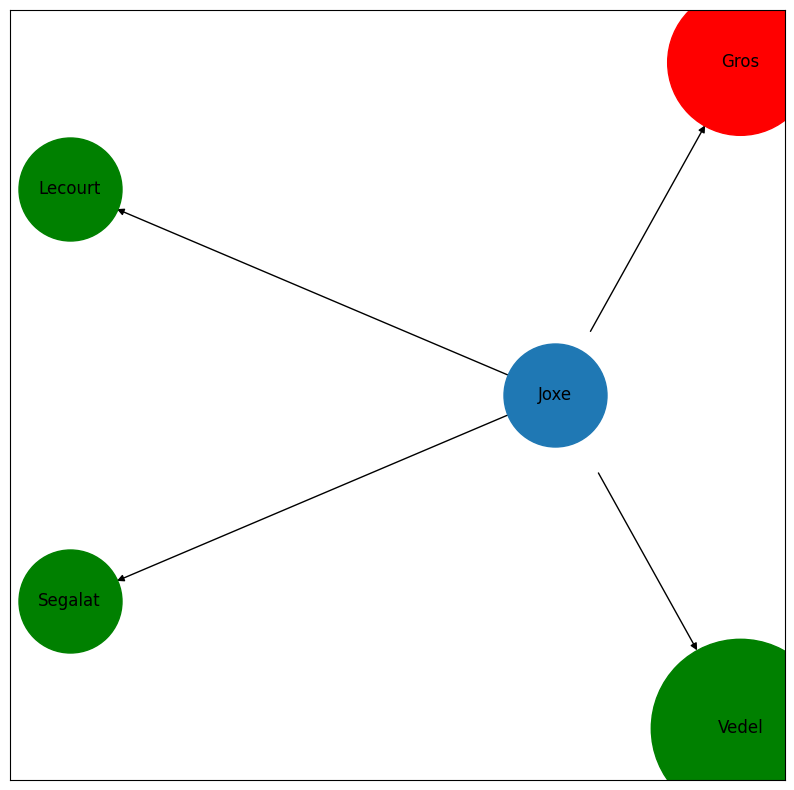

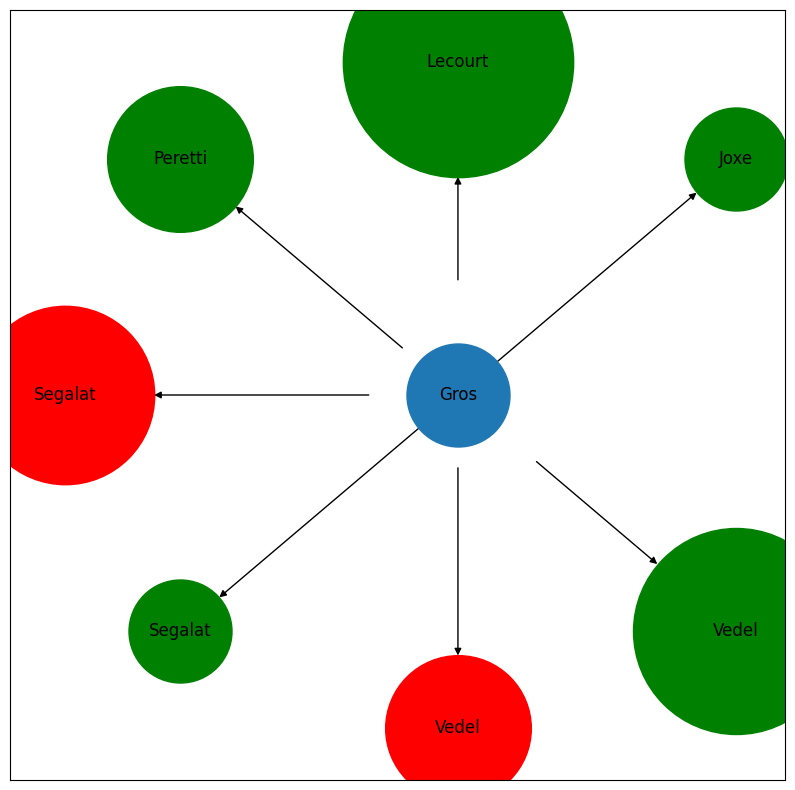

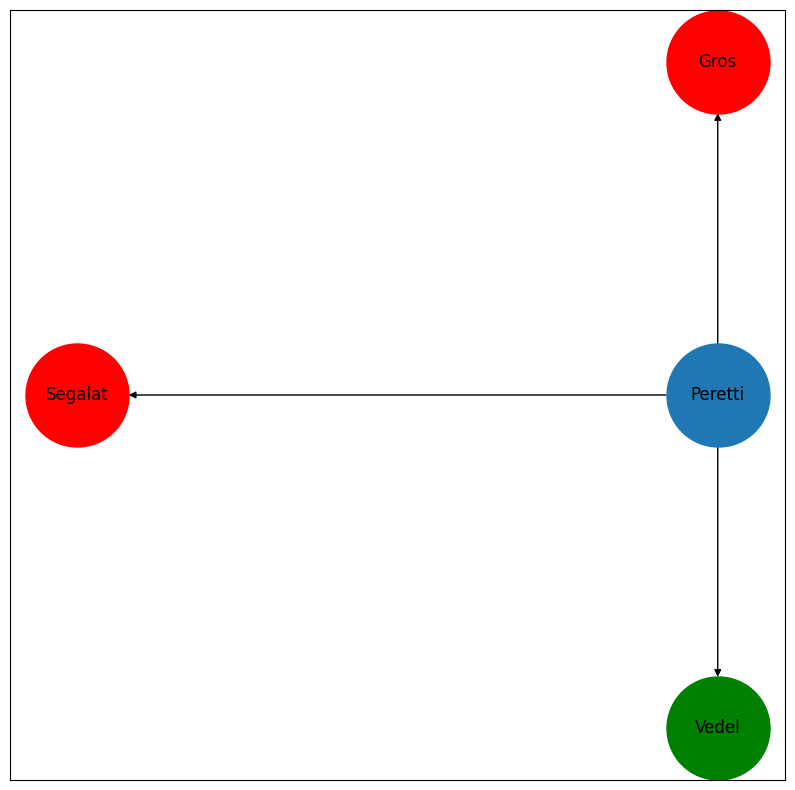

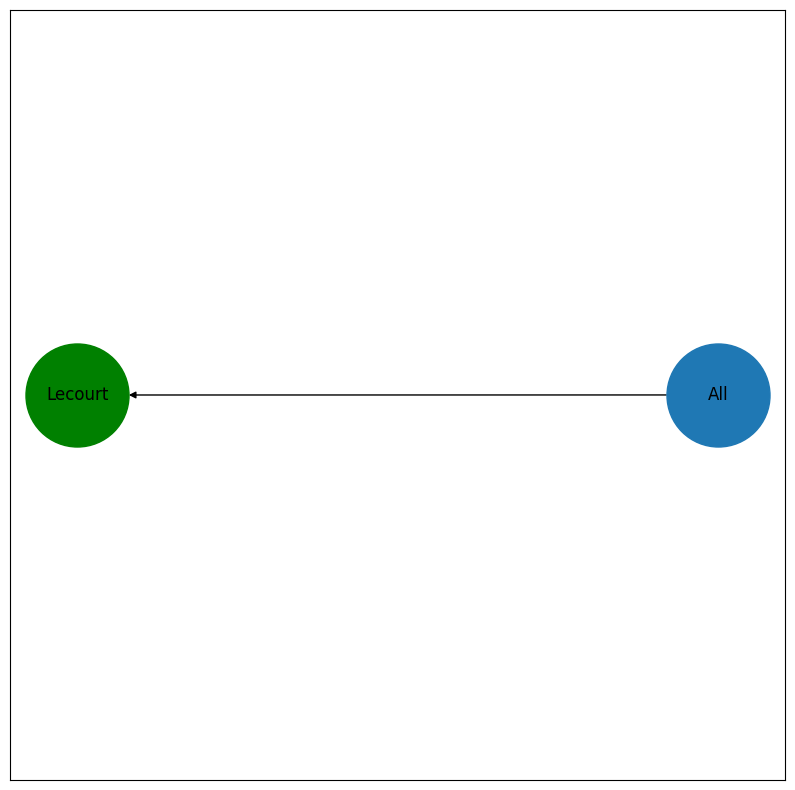

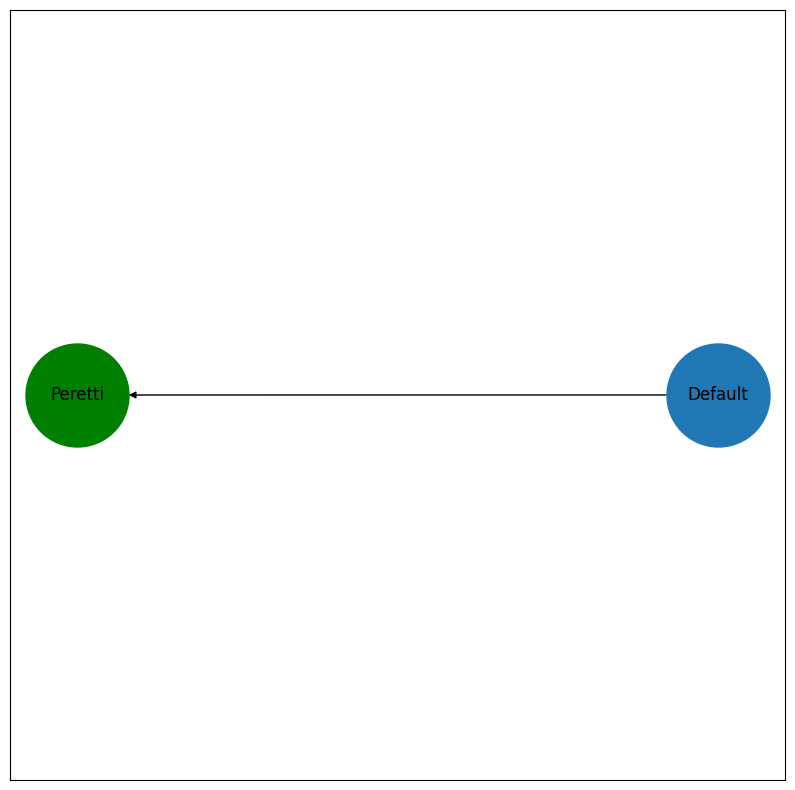

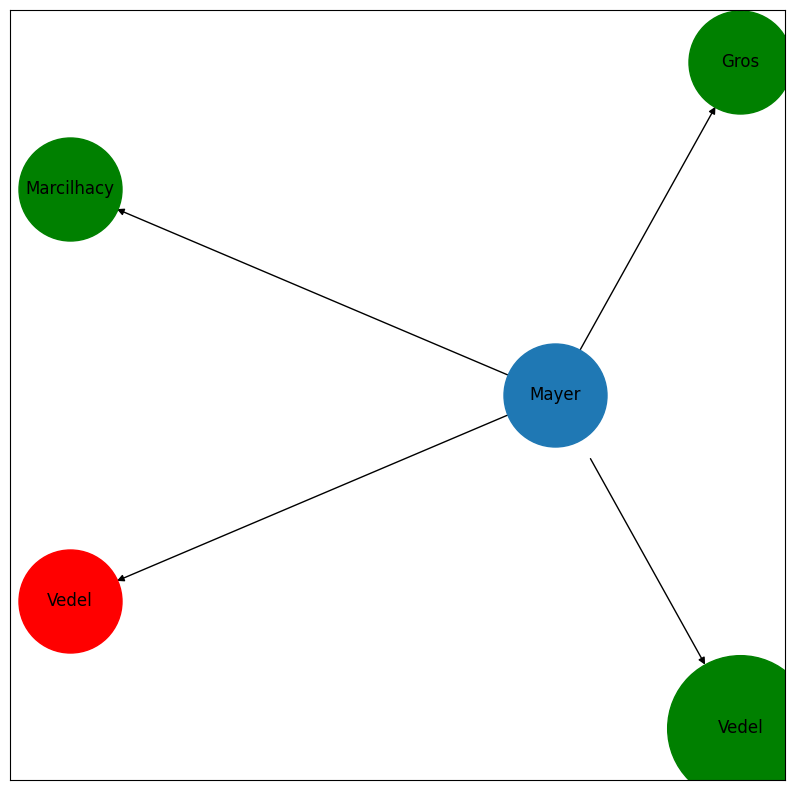

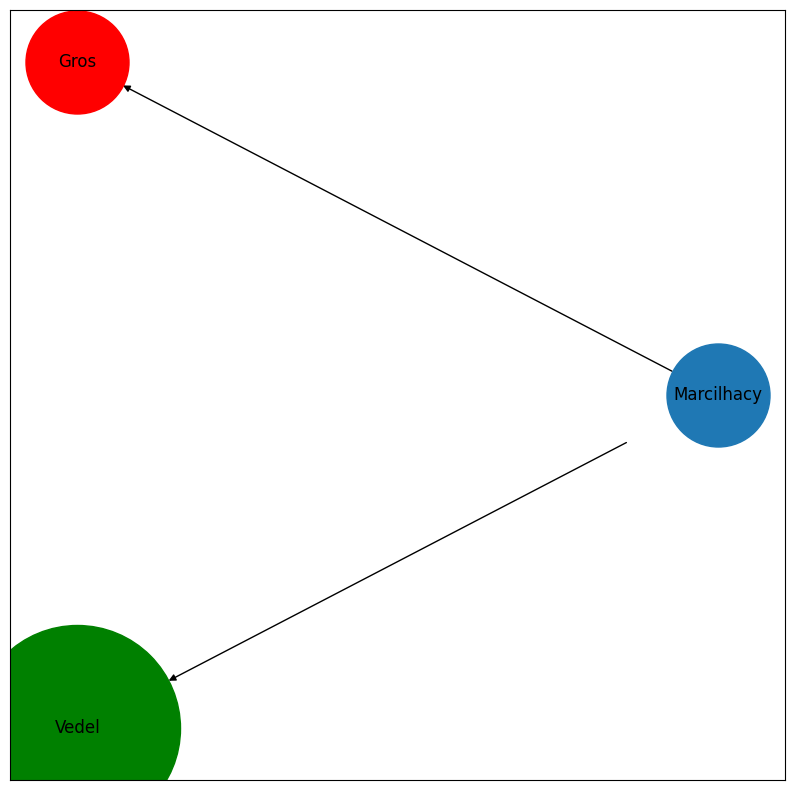

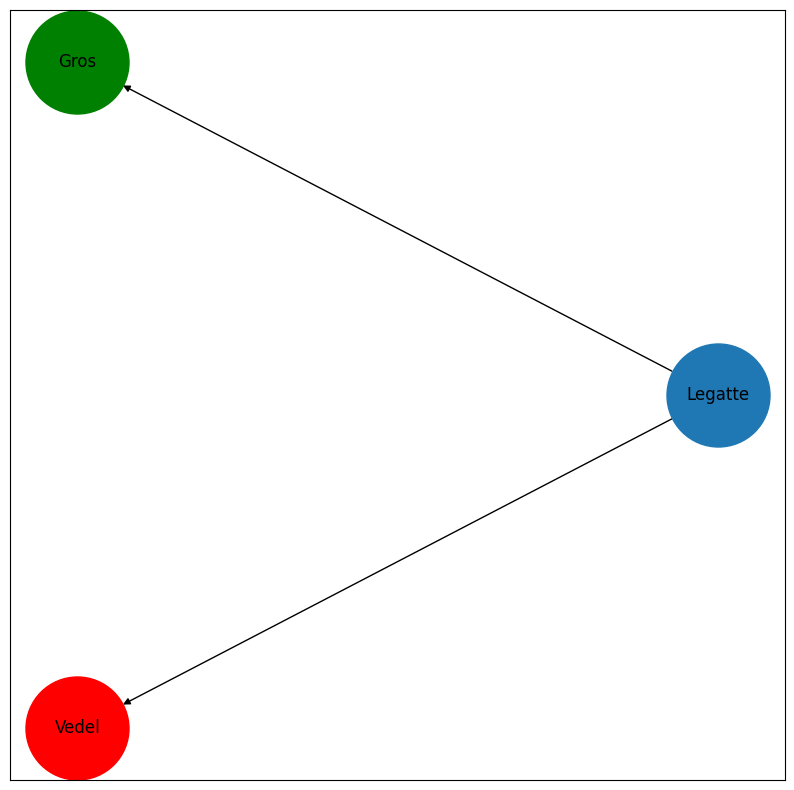

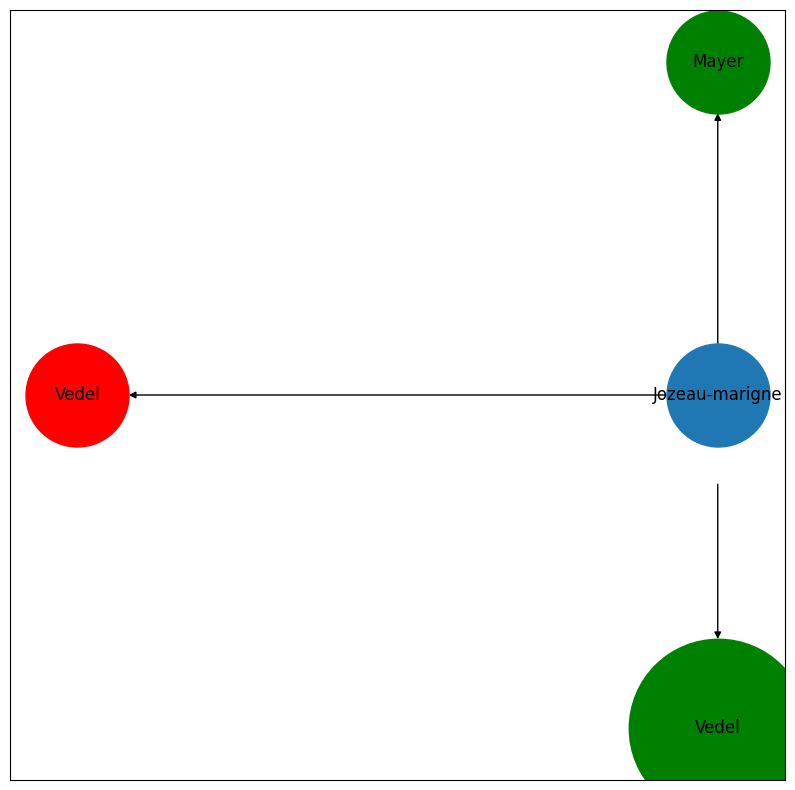

In [101]:
plt.figure(figsize=(10,10)) 
scale = 5500

for speaker in df.speaker.unique():
    plt.figure(figsize=(10,10)) 
    df_sp = df[df['speaker']==speaker]

    d = defaultdict(dict)
    for n in df_sp.groupby(['target', 'type']).count().iterrows():
        d[n[0][0]][n[0][1]]=n[1][0]

    G = nx.DiGraph()
    for k, v in d.items():
        for kk, vv in v.items():
            G.add_edge(speaker, k+kk)

    pos = nx.circular_layout(G)
    pos[speaker]=[0,0]
    # print(pos)
    nx.draw_networkx_nodes(G, pos, nodelist=[speaker], node_size=scale)
    nx.draw_networkx_labels(G, pos, labels={speaker:speaker[1:].split('_')[0].capitalize()})
    for k, v in d.items():
        for kk, vv in v.items():
            nx.draw_networkx_nodes(G, pos, nodelist=[k+kk], node_color='green' if kk=='POSITIF' else 'red', node_size=vv*scale)
            # nx.draw_networkx_edges(G, pos, edgelist=[(speaker,k+kk)], node_size=vv*scale, connectionstyle="arc3,rad=0.45")
            nx.draw_networkx_edges(G, pos, edgelist=[(speaker,k+kk)], node_size=vv*scale)
            nx.draw_networkx_labels(G, pos, labels={k+kk:k[1:].split('_')[0].capitalize()})
    plt.show()

In [71]:
df_gold = pd.read_csv(f'data/82_speaker_target.csv')

In [22]:
ids = []

def is_p(p, sentence):
    return sentence.strip() in p[2]

for i,sentence in enumerate(df_gold.sent_text.unique()):
    m_list = list(filter(lambda x: is_p(x, sentence), mentions))
    ids.append(len(m_list))

    # assert len(m_list)>0, f"{i}, {sentence}"
    assert len(m_list)>0, f"{i}, {df_gold[df_gold['sent_text']==sentence]}"

    if len(m_list)>1:
        print(i)
        print(sentence)
        print(df_gold[df_gold['sent_text']==sentence][['mention_text', 'is_speaker']])
        print([m[0] for m in m_list])

98
Après la lecture de ce projet de décision, Monsieur le Président déclare ouverte la discussion générale.
    mention_text  is_speaker
123    Président        True
179    Président        True
224    Président        True
['Président', 'Président', 'Président']
277
Monsieur le Président indique que l'ordre du jour est le suivant :
    mention_text  is_speaker
406    Président        True
['', 'Président']


In [63]:
def eval_speaker(row):
    m = list(filter(lambda x: is_p(x, row['sent_text']), mentions))[-1]
    if row['is_speaker']:
        return  m[0], match_person({'mention_text':m[0], 'decision_id':m[3]}) == match_person(row)
    return m[0], None

In [79]:
def eval_target(row):
    m = list(filter(lambda x: is_p(x, row['sent_text']), mentions))[-1]
    if row['is_target']:
        for target in m[1]:
            if match_person({'mention_text':target, 'decision_id':m[3]}) == match_person(row):
                return m[1], True
        return m[1], False
    return m[1], None

In [80]:
df_gold[['pred_speaker', 'eval_speaker']] = df_gold.apply(eval_speaker, axis=1).tolist()
df_gold[['pred_target', 'eval_target']] = df_gold.apply(eval_target, axis=1).tolist()

c:\ProgramData\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


In [83]:
df_gold[df_gold['eval_speaker']==False][['sent_text', 'mention_text', 'pred_speaker', 'is_speaker', 'file_name']]

,sent_text,mention_text,pred_speaker,is_speaker,file_name
9,Monsieur PERETTI et Monsieur JOXE sont d'accor...,JOXE,PERETTI,True,PV1982-01-05
67,Monsieur MONNERVILLE remercie Monsieur LECOURT...,MONNERVILLE,,True,PV1982-02-18-23
137,Monsieur GROS rappelle qu'il était rapporteur ...,rapporteur,GROS,True,PV1982-06-28
160,Monsieur SEGALAT déclare se rallier à la propo...,SEGALAT,VEDEL,True,PV1982-06-28
251,"Selon le Doyen VEDEL, l'article 34 n'invoquant...",VEDEL,SEGALAT,True,PV1982-07-30
265,Messieurs BROUILLET et MONNERVILLE déclarent a...,MONNERVILLE,BROUILLET,True,PV1982-07-30
287,Monsieur VEDEL présente le rapport suivant.,VEDEL,Président,True,PV1982-11-10
308,"En effet, Monsieur PERETTI expose que la loi d...",PERETTI,VEDEL,True,PV1982-11-18
339,"Monsieur VEDEL s'étant retiré, Monsieur le Pré...",Président,VEDEL,True,PV1982-11-18
341,"Monsieur VEDEL s'étant retiré, Monsieur le Pré...",GROS,VEDEL,True,PV1982-11-18


In [34]:
m_list

[('MONNERVILLE',
  [],
  'Monsieur MONNERVILLE lève alors la séance à 18 h 10.',
  '',
  'PV1982-12-29')]

In [26]:
df_gold.apply(lambda x: print(x['file_name']), axis=1)

PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-01-05
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-11
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-23
PV1982-02-18-2

0      None
1      None
2      None
3      None
4      None
       ... 
485    None
486    None
487    None
488    None
489    None
Length: 490, dtype: object

In [ ]:
def get_mention_item(idx, mentions):
    def wrapped_get_mention_item(sent_text):
        m_list = list(filter(lambda x: is_p(x, sentence), mentions))
        

In [ ]:
p = pd.DataFrame(mentions, columns=['mention_text', ])